#Transfer Learning with TensorFlow Part 1: Feature Extraction

## Multi-class Classification

We've referenced the TinyVGG architecture from the CNN Explainer website multiple times however, the CNN Explainer website works with 10 different image classes, where as our current model(previous notebook) only works with two classes (pizza and steak).


How about we go through those steps again, except this time, we'll work with 10 different types of food.

1. Become one with the data
2. Preprocess the data (prepare it for a model)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat our baseline)
7. Repeat until satisfied

### 1. Import and become one with the data

Again, we've got a subset of the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101). In addition to the pizza and steak images, we've pulled out another eight classes.


In [ ]:
import zipfile

# Download zip file of 10_food_classes images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-07-05 13:41:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  52.8MB/s    in 11s     

2022-07-05 13:41:52 (46.1 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



Now let's check out all of the different directories and sub-directories in the 10_food_classes file.

In [ ]:
import os

# Walk through 10_food_classes directory and list number of files- all from food101 kaggle
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.

In [ ]:
#We'll now setup the training and test directory paths.
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

####And get the class names from the subdirectories.


In [ ]:
# Get the class names for our multi-class dataset/ alternate to TF imagegen
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)#10_food_classes_all_data/train
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


How about we visualize an image from the training set?

In [ ]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class # both in string format
  print(f'The target_folder is:{target_folder}')

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1) # randomly sample 1 image from the target_folder
  print(f'The random_image is:{random_image}') # image in image_name.jpg format
  

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  print(f"Image shape: {img.shape}") # show the shape of the image
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");
  return img

The target_folder is:10_food_classes_all_data/train/fried_rice
The random_image is:['720602.jpg']
Image shape: (512, 512, 3)


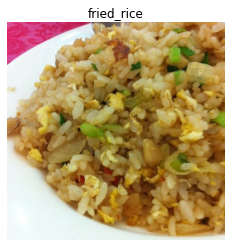

In [ ]:
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name, any among 10 labels

### 2. Preprocess the data (prepare it for a model)

After going through a handful of images (it's good to visualize at least 10-100 different examples), it looks like our data directories are setup correctly.

Time to preprocess the data.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical from binary as we have 10 classes

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 3. Create a model (start with a baseline)

We can use the same model (TinyVGG) we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

Namely:
* Changing the output layer to use have 10 ouput neurons (the same number as the number of classes we have).
* Changing the output layer to use `'softmax'` activation instead of `'sigmoid'` activation.
* Changing the loss function to be `'categorical_crossentropy'` instead of `'binary_crossentropy'`.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model
model_1 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation instead of sigmoid
]) 
# Compile the model
model_1.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(), # can also use RMSprop, Adagrad, Adadelta, 
                metrics=["accuracy"]) # can capture any metric



### 4. Fit a model

Now we've got a model suited for working with multiple classes, let's fit it to our data.

In [ ]:
# Fit the model
history_1 = model_1.fit(train_data, # now 10 different classes 
                        epochs=5, 
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 58s 191ms/step - loss: 2.2496 - accuracy: 0.1541 - val_loss: 2.1699 - val_accuracy: 0.1912
Epoch 2/5
235/235 [==============================] - 44s 187ms/step - loss: 2.0080 - accuracy: 0.2920 - val_loss: 1.9501 - val_accuracy: 0.2952
Epoch 3/5
235/235 [==============================] - 44s 189ms/step - loss: 1.7733 - accuracy: 0.3869 - val_loss: 2.0609 - val_accuracy: 0.3204
Epoch 4/5
235/235 [==============================] - 44s 187ms/step - loss: 1.4221 - accuracy: 0.5212 - val_loss: 2.0352 - val_accuracy: 0.3204
Epoch 5/5
235/235 [==============================] - 45s 190ms/step - loss: 0.9369 - accuracy: 0.6937 - val_loss: 2.5275 - val_accuracy: 0.2876


Epoch takes longer compare to when working with only two classes of images!

It's because we're now dealing with more images than we were before. We've got 10 classes with 750 training images and 250 validation images each totalling 10,000 images. 

Where as when we had two classes, we had 1500 training images and 500 validation images, totalling 2000.

The intuitive reasoning here is the more data we have, the longer a model will take to find patterns.

### 5. Evaluate the model

We've just trained a model on 10 different classes of food images, let's see how it went.

In [ ]:
# Evaluate on the test data
model_1.evaluate(test_data)

79/79 [==============================] - 11s 133ms/step - loss: 2.5275 - accuracy: 0.2876


[2.5274558067321777, 0.28760001063346863]

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure() # 2nd figure
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

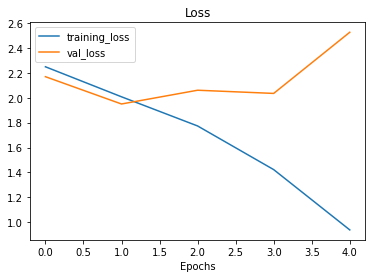

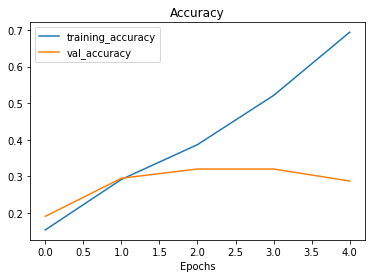

In [ ]:
# Check out the model's loss curves on the 10 classes of data
plot_loss_curves(history_1)

Woah, that's quite the gap between the training and validation loss curves.

It seems our model is overfitting the training set quite badly. In other words, it's getting great results on the training data but fails to generalize well to unseen data and performs poorly on the test data.


### 6. Adjust the model parameters

Due to its performance on the training data, it's clear our model is learning something but not able to generalize well on the test data.

So our next steps will be to try and prevent our model overfitting. A couple of ways to prevent overfitting include:

- **Get more data** - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.

- **Simplify model** - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.


- **Use data augmentation** - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.

- **Use transfer learning** - Transfer learning involves leverages the patterns one model has learned to use as the foundation for our own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.

We'll most likely to try one or a combination of the last three above options first to improve our model accuracy and avoid overfitting.

Since collecting more data would involve us manually taking more images of food, let's try the ones we can do from right within the notebook.

How about we simplify our model first?

To do so, we'll remove two of the convolutional layers, taking the total number of convolutional layers from four to two.

Let's try **data augmentation**?

Data augmentation makes it harder for the model to learn on the training data and in turn, hopefully making the patterns it learns more generalizable to unseen data.

In [ ]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 7500 images belonging to 10 classes.


Now we've got augmented data, let's see how it works with the same model.

Rather than rewrite the model from scratch, we can clone it using a handy function in TensorFlow called [`clone_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) which can take an existing model and rebuild it in the same format. 

The cloned version will not include any of the weights (patterns) the original model has learned. So when we train it, it'll be like training a model from scratch.

In [ ]:
# Clone the model (use the same architecture)
model_2 = tf.keras.models.clone_model(model_1) # check summary for both

# Compile the cloned model (same setup as used for model_10)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 110s 468ms/step - loss: 2.1689 - accuracy: 0.2132 - val_loss: 1.9668 - val_accuracy: 0.2860
Epoch 2/5
235/235 [==============================] - 109s 466ms/step - loss: 2.0390 - accuracy: 0.2775 - val_loss: 1.8851 - val_accuracy: 0.3340
Epoch 3/5
235/235 [==============================] - 108s 461ms/step - loss: 1.9787 - accuracy: 0.3103 - val_loss: 1.8560 - val_accuracy: 0.3384
Epoch 4/5
235/235 [==============================] - 108s 461ms/step - loss: 1.9468 - accuracy: 0.3151 - val_loss: 1.7759 - val_accuracy: 0.4052
Epoch 5/5
235/235 [==============================] - 109s 462ms/step - loss: 1.8975 - accuracy: 0.3441 - val_loss: 1.8092 - val_accuracy: 0.3820


We can see it each epoch takes longer than the previous model. This is because our data is being augmented on the CPU as it gets loaded onto the GPU, in turn, increasing the amount of time between each epoch.

How do our model's training curves look?


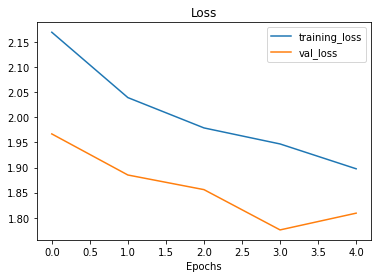

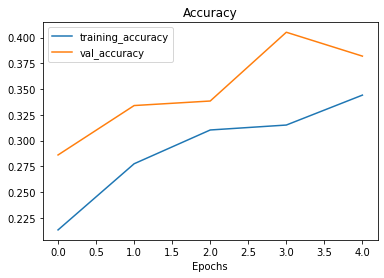

In [ ]:
# Check out our model's performance with augmented data
plot_loss_curves(history_2)

That's looking much better, the loss curves are much closer and parallel to one other. Although our model didn't perform as well on the augmented training set, it performed much better on the validation dataset.

It even looks like if we kept it training for longer (more epochs) the evaluation metrics might continue to improve.


### 7. Repeat until satisfied

We could keep going here. Restructuring our model's architecture, adding more layers, trying it out, adjusting the learning rate, trying it out, trying different methods of data augmentation, training for longer. But time constraints is always an issue

Good thing there's still one trick we haven't tried yet and that's **transfer learning**. 

In the meantime, let's make a prediction with our trained multi-class model.

## Making a prediction with our trained model

What good is a model if we can't make predictions with it?

Let's first remind ourselves of the classes our multi-class model has been trained on and then we'll download some of own custom images to work with.

Now let's get some of our custom images.


In [ ]:
# -q is for "quiet" - we can directly upload the images via the upload button
!wget -q https://cdn.britannica.com/52/128652-050-14AD19CA/Maki-zushi.jpg
!wget -q https://www.whiskaffair.com/wp-content/uploads/2020/07/Tomato-Chicken-Curry-2-3.jpg
!wget -q https://www.licious.in/blog/wp-content/uploads/2020/12/Sesame-Chicken-Noodles.jpg
!wget -q https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/delish-190611-coconut-ice-cream-009-portrait-pf-1561393438.png
!wget -q https://assets.epicurious.com/photos/57c5c6d9cf9e9ad43de2d96e/master/pass/the-ultimate-hamburger.jpg

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[tf.argmax(pred[0])] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0])] # if only one output, round, add [0] is error

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

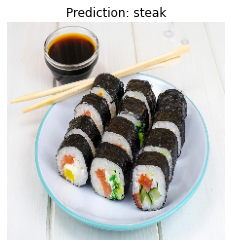

In [ ]:
# Make a prediction using model_2
pred_and_plot(model=model_2, 
              filename="Maki-zushi.jpg", 
              class_names=class_names)

Hmm... it looks like our model got the prediction wrong, how about we try another?

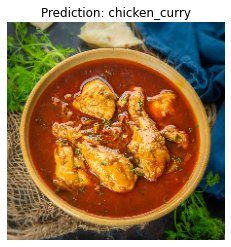

In [ ]:
pred_and_plot(model_2, "Tomato-Chicken-Curry-2-3.jpg", class_names)

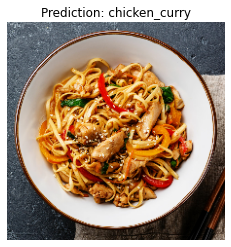

In [ ]:
pred_and_plot(model_2, "Sesame-Chicken-Noodles.jpg", class_names)


Let's makes a prediction without using the function and see where it might be going wrong.


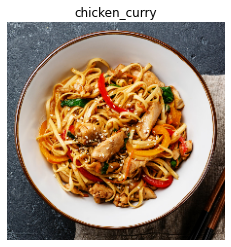

In [ ]:
# Load in and preprocess our custom image
img = load_and_prep_image("Sesame-Chicken-Noodles.jpg")

# Make a prediction
pred = model_2.predict(tf.expand_dims(img, axis=0))
# Match the prediction class to the highest prediction probability
pred_class = class_names[pred.argmax()]
plt.imshow(img)
plt.title(pred_class)
plt.axis(False);

There must be something up with our pred_and_plot function.

The pred_and_plot function was designed to be used with binary classification models where as our current model is a multi-class classification model.

The main difference lies in the output of the predict function.


In [ ]:
# Check the output of the predict function
pred = model_2.predict(tf.expand_dims(img, axis=0))
pred

array([[0.3631268 , 0.16462123, 0.0161434 , 0.2252213 , 0.05250837,
        0.00284593, 0.0088821 , 0.05963128, 0.09848025, 0.00853932]],
      dtype=float32)

Since our model has a 'softmax' activation function and 10 output neurons, it outputs a prediction probability for each of the classes in our model.

The class with the highest probability is what the model believes the image contains.

We can find the maximum value index using argmax and then use that to index our class_names list to output the predicted class.


In [ ]:
# Find the predicted class name
class_names[pred.argmax()]

'chicken_curry'

Let's try it out. If we've done it right, using different images should lead to different outputs (rather than chicken_curry every time).

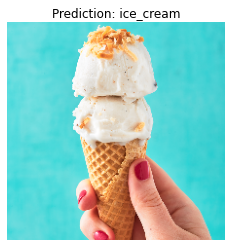

In [ ]:
pred_and_plot(model_2, "delish-190611-coconut-ice-cream-009-portrait-pf-1561393438.png", class_names)

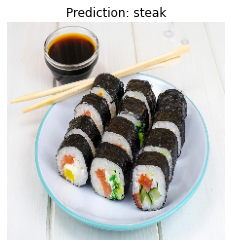

In [ ]:
pred_and_plot(model_2, "Maki-zushi.jpg", class_names)

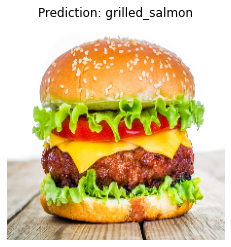

In [ ]:
pred_and_plot(model_2, "the-ultimate-hamburger.jpg", class_names)

Our model's predictions aren't very good, this is because it's only performing at ~35% to ~40% accuracy on the test dataset. 

## Saving and loading our model

Once we've trained a model, we probably want to be able to save it and load it somewhere else.

To do so, we can use the [`save`](https://www.tensorflow.org/tutorials/keras/save_and_load) and `load_model`

In [ ]:
# Save a model
model_2.save("saved_trained_model")

INFO:tensorflow:Assets written to: saved_trained_model/assets


In [ ]:
# Load in a model and evaluate it
loaded_model_2 = tf.keras.models.load_model("saved_trained_model")
loaded_model_2.evaluate(test_data)

79/79 [==============================] - 11s 131ms/step - loss: 1.8092 - accuracy: 0.3820


[1.8092405796051025, 0.38199999928474426]

In [ ]:
# Compare our unsaved model's results (same as above)
model_2.evaluate(test_data)

79/79 [==============================] - 10s 131ms/step - loss: 1.8092 - accuracy: 0.3820


[1.8092402219772339, 0.38199999928474426]

#CNN with Transfer Learning

Transfer learning, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.

2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as ImageNet (millions of images of different objects) or EfficientNetBx and use them as the foundation of our own. Doing this often leads to getting great results with less data.


Transfer leanring with TensorFlow Hub: Getting great results with 10% of the data(working with 10% of every class). TensorFlow Hub is a repository for existing model components. It makes it so we can import and use a fully trained model with as little as a URL.

So this is where another major benefit of transfer learning comes in.

Transfer learning often allows us to get great results with less data

What we're working towards building. Taking a pre-trained model and adding our own custom layers on top, extracting all of the underlying patterns learned on another dataset our own images.

In [ ]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-07-05 13:56:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   284MB/s    in 0.6s    

2022-07-05 13:56:59 (284 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.") 
# test data is same but training data is reduced to 10% ie from 750 in each class to 75

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

Notice how each of the training directories now has 75 images rather than 750 images. This is key to demonstrating how well transfer learning can perform with less labelled images.

The test directories still have the same amount of images. This means we'll be training on less data but evaluating our models on the same amount of test data.


Creating data loaders (preparing the data)

Now we've downloaded the data, let's use the ImageDataGenerator class along with the flow_from_directory method to load in our images.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224) # something  in capital letters is hyperparameters in DL
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


Loading in the data we can see we've got 750 images in the training dataset belonging to 10 classes (75 per class) and 2500 images in the test set belonging to 10 classes (250 per class).

## Setting up callbacks- To Save weights/ Model 

[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality we can add to our models to be performed during or after training. Some of the most popular callbacks include:

* [**Experiment tracking with TensorBoard**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - log the performance of multiple models and then view and compare these models in a visual way on [TensorBoard](https://www.tensorflow.org/tensorboard) (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on our data.

* [**Model checkpointing**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - save our model as it trains so we can stop training if needed and come back to continue off where we left. Helpful if training takes a long time and can't be done in one sitting.

* [**Early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - leave our model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when we have a large dataset and don't know how long training will take.

* Many more on Tensorflow website


The TensorBoard callback can be accessed using [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard). 


To track our modelling experiments using TensorBoard, let's create a function which creates a TensorBoard callback for us.




In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)- tracking performances of each model we create in 1 folder 
import datetime # to track when our model was run
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # stringfromtime
  tensorboard_callback = tf.keras.callbacks.TensorBoard( # every single callbacks from callbacks module
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In our case, our function saves a model's performance logs to a directory named [dir_name]/[experiment_name]/[current_timestamp], where:

1. dir_name is the overall logs directory
2. experiment_name is the particular experiment
3. current_timestamp is the time the experiment started based on Python's datetime.datetime().now()


## Creating models using TensorFlow Hub

Before we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from [TensorFlow Hub](https://tfhub.dev/).

In fact, we're going to use two models from TensorFlow Hub:
1. ResNetV2 - computer vision model architecture from 2016.
2. EfficientNet- computer vision architecture from 2019.
3. Resnet and efficientnet are both good models for image classification. But the best model is not always best for our model

Both of these models have achieved the lowest error rate on ImageNet

But Tensorflow Hub has many model available and it creates a confusion which one to use. One solution is to check a list of state of the art models on [paperswithcode.com](https://www.paperswithcode.com), a resource for collecting the latest in deep learning paper results which have code implementations for the findings they report.

Since we're working with images, our target are the [models which perform best on ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet). Imagenet is a big repository of all different types of classes

Not all model architectures listed on paperswithcode appear on TensorFlow Hub. 

On the Tensorflow Hub, we find feature_vector and classification for EfficientNet.

**"In transfer learning** we take a pretrained model as it is and apply it to our task without any changes. 

  * Many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class). 

    * This is helpful if we have 1000 classes of image, however, it's not helpful if we want to classify only a small subset of classes (such as 10 different kinds of food). Model's with `"/classification"` in their name on TensorFlow Hub provide this kind of functionality.


Now we'll get the feature vector URLs of two common computer vision architectures, [EfficientNetB0 (2019)](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1) and [ResNetV250 (2016)](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4) from TensorFlow Hub using the steps above.

We're getting both of these because we're going to compare them to see which performs better on our data.


In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

efficientnet_v2_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2"

These URLs link to a saved pretrained model on TensorFlow Hub.

When we use them in our model, the model will automatically be downloaded for us to use.

To do this, we can use the KerasLayer() model inside the TensorFlow hub library.

Since we're going to be comparing two models, to save ourselves code, we'll create a function create_model(). This function will take a model's TensorFlow Hub URL, instatiate a Keras Sequential model with the appropriate number of output layers and return the model.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # keep the underlying patterns frozen, false because above models have already been train on imagenet
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape ie fancy way of writing (224,224,3)
                                           #  feature_extractor_layer is not trainable during training
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base created above
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer after feature layer  
  ])

  return model

Great! Now we've got a function for creating a model, we'll use it to first create a model using the ResNetV250 architecture as our feature extraction layer.


In [ ]:
#Checking the number of classes
train_data_10_percent.num_classes

10

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile the resnet model directly as it has been already trained on imagenet dataset
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

The above model is only going to train on our output layer as trainable was set to false i.e all resnet layer are frozen


In [ ]:
resnet_model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


Time to fit the model.

We've got the training data ready in `train_data_10_percent` as well as the test data saved as `test_data`.

We'll also  add TensorBoard callback so we can track the performance of our model on TensorBoard.

We can add a callback to our model by using the `callbacks` parameter in the fit function.

In our case, we'll pass the `callbacks` parameter the `create_tensorboard_callback()` we created earlier with some specific inputs so we know what experiments we're running.

Let's keep this experiment short and train for 5 epochs.

In [ ]:
# from matplotlib import test
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50v2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20220705-142228
Epoch 1/5
24/24 [==============================] - 17s 721ms/step - loss: 0.3108 - accuracy: 0.9453 - val_loss: 0.6795 - val_accuracy: 0.7704
Epoch 2/5
24/24 [==============================] - 15s 664ms/step - loss: 0.2629 - accuracy: 0.9547 - val_loss: 0.6539 - val_accuracy: 0.7812
Epoch 3/5
24/24 [==============================] - 15s 663ms/step - loss: 0.2159 - accuracy: 0.9680 - val_loss: 0.6449 - val_accuracy: 0.7836
Epoch 4/5
24/24 [==============================] - 15s 656ms/step - loss: 0.1842 - accuracy: 0.9760 - val_loss: 0.6432 - val_accuracy: 0.7824
Epoch 5/5
24/24 [==============================] - 15s 662ms/step - loss: 0.1588 - accuracy: 0.9867 - val_loss: 0.6375 - val_accuracy: 0.7880


It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made earlier, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...with only 10 percent of the training images!

That goes to show the power of transfer learning. 

Let's check out our model's training curves using our plot_loss_curves function.

In [ ]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately, will work only for metrics=['accuracy'] else plot_loss_curve will fail 
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
  #Transfer Learning shines when input data by default is limited 

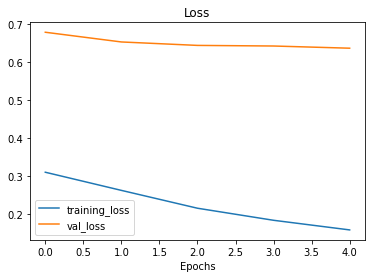

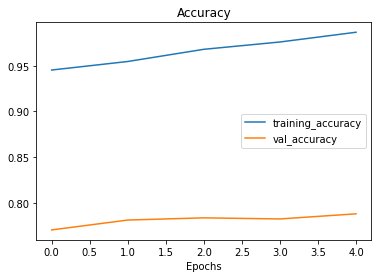

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
# Resnet summary 
resnet_model.summary() # Params are weights and biases of the resnet_layer

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


We can see the power of TensorFlow Hub here. The feature extraction layer has 23,564,800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since we set trainable=False, these patterns remain frozen (non-trainable) during training.

This means during training the model updates only the 20,490 parameters in the output layer to suit our dataset.

We've trained a ResNetV250 model, time to do the same with EfficientNetB0 model.

The setup will be the exact same as before, except for the model_url parameter in the create_model() function and the experiment_name parameter in the create_tensorboard_callback() function.


In [ ]:
# Create model this is just B0 it goes all the way to B7 so imagine the accuracy level
efficientnet_model = create_model(model_url=efficientnet_url, 
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220705-145436
Epoch 1/5
24/24 [==============================] - 26s 721ms/step - loss: 1.9152 - accuracy: 0.3960 - val_loss: 1.3230 - val_accuracy: 0.7180
Epoch 2/5
24/24 [==============================] - 15s 634ms/step - loss: 1.0808 - accuracy: 0.7653 - val_loss: 0.8782 - val_accuracy: 0.8092
Epoch 3/5
24/24 [==============================] - 15s 634ms/step - loss: 0.7589 - accuracy: 0.8320 - val_loss: 0.7077 - val_accuracy: 0.8376
Epoch 4/5
24/24 [==============================] - 15s 633ms/step - loss: 0.6078 - accuracy: 0.8640 - val_loss: 0.6117 - val_accuracy: 0.8560
Epoch 5/5
24/24 [==============================] - 15s 636ms/step - loss: 0.5099 - accuracy: 0.8893 - val_loss: 0.5571 - val_accuracy: 0.8624


The EfficientNetB0 model does even better than the ResNetV250 model! 

Achieving over 85% accuracy on the test set...again with only 10% of the training data.

With a couple of lines of code we're able to leverage state of the art models and adjust them to our own use case.

Let's check out the loss curves.


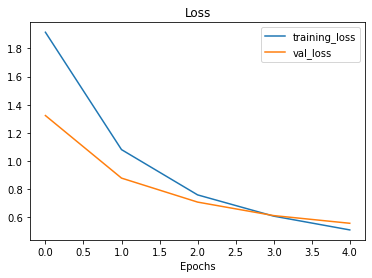

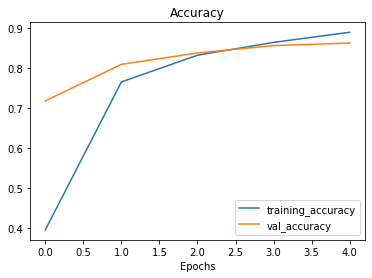

In [ ]:
plot_loss_curves(efficientnet_history)

From the look of the EfficientNetB0 model's loss curves, it looks like if we kept training our model for longer, it might improve even further.

Let's check out the model summary.


In [ ]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


The EfficientNetB0 feature extraction layer yields better performance. Let's check the latest EfficientNetV2 model and compare the results


In [ ]:
# Create model this is just B0 it goes all the way to B7 so imagine the accuracy level
efficientnetV2_model = create_model(model_url=efficientnet_v2_url, 
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnetV2_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnetV2_history = efficientnetV2_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetV2")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetV2/20220705-145941
Epoch 1/5
24/24 [==============================] - 27s 756ms/step - loss: 2.0482 - accuracy: 0.4307 - val_loss: 0.6257 - val_accuracy: 0.7972
Epoch 2/5
24/24 [==============================] - 16s 675ms/step - loss: 0.4929 - accuracy: 0.8373 - val_loss: 0.3773 - val_accuracy: 0.8684
Epoch 3/5
24/24 [==============================] - 16s 677ms/step - loss: 0.2495 - accuracy: 0.9267 - val_loss: 0.3277 - val_accuracy: 0.8872
Epoch 4/5
24/24 [==============================] - 16s 687ms/step - loss: 0.1608 - accuracy: 0.9587 - val_loss: 0.2996 - val_accuracy: 0.9004
Epoch 5/5
24/24 [==============================] - 16s 675ms/step - loss: 0.1172 - accuracy: 0.9787 - val_loss: 0.2852 - val_accuracy: 0.9064


Our EfficientNetV2 model is even more better than EffcientNetB0

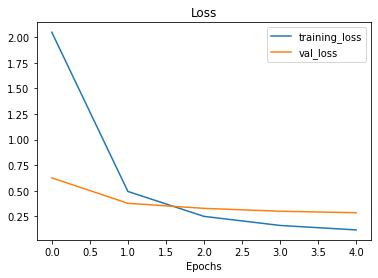

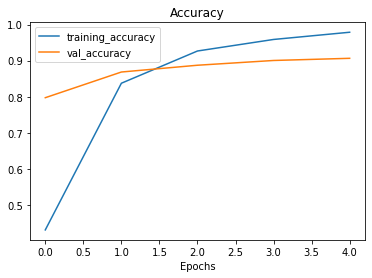

In [ ]:
plot_loss_curves(efficientnetV2_history)

In [ ]:
efficientnetV2_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1536)             12930622  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                15370     
                                                                 
Total params: 12,945,992
Trainable params: 15,370
Non-trainable params: 12,930,622
_________________________________________________________________


In [ ]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


Our efficientnetV2_model is using x3 times more weights and biases(params) compare to EfficientNetB0 model yet only a slight different in val accuracy. 

For this reason, we will further use EfficientNetB0 itself

## Comparing models using TensorBoard

Alright, even though we've already compared the performance of our three models by looking at the accuracy scores. It's always a good practice to track model experiments.

That's where an experiment tracking tool like [TensorBoard](https://www.tensorflow.org/tensorboard) (preinstalled in Google Colab) comes in.

The good thing is, since we set up a TensorBoard callback, all of our model's training logs have been saved automatically. To visualize them, we can upload the results to [TensorBoard.dev](https://tensorboard.dev/).

Uploading the results to TensorBoard.dev enables us to track and share multiple different modelling experiments. So if we needed to show the results, we could send them a link to our TensorBoard.dev as well as the accompanying Colab notebook.


## Uploading experiments to TensorBoard

To upload a series of TensorFlow logs to TensorBoard, we can use the following command:

```
Upload TensorBoard dev records. ./tensorflow_hub/ is the directory of our colab

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \ 
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \ 
  --one_shot
```

Where:
* `--logdir` is the target upload directory
* `--name` is the name of the experiment
* `--description` is a brief description of the experiment
* `--one_shot` exits the TensorBoard uploader once uploading is finished

Running the `tensorboard dev upload` command will first ask us to authorize the upload to TensorBoard.dev. After we've authorized the upload, our log files will be uploaded.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs. EfficientNetV2 vs. ResNet50V2 " \
--description "Comparing three different TF Hub feature extraction models architectures using 10% of training images" \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=WXtQ3HibQ8p5nZfcEPIoEoU9r35tTc&prompt=consent&access_type=off

Every time we upload something to TensorBoad.dev we'll get a new experiment ID.

To see all of the experiments we've uploaded we can use the command:

```tensorboard dev list```

In [ ]:
# Check out experiments all the list till now
!tensorboard dev list

https://tensorboard.dev/experiment/ymFVaUZwQyCVojIwrDdxbg/
	Name                 EfficientNetB0 vs. EfficientNetV2 vs. ResNet50V2 
	Description          Comparing three different TF Hub feature extraction models architectures using 10% of training images
	Id                   ymFVaUZwQyCVojIwrDdxbg
	Created              2022-07-05 15:52:24 (1 minute ago)
	Updated              2022-07-05 15:52:33 (1 minute ago)
	Runs                 8
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  11726532
Total: 1 experiment(s)


Deleting experiments from TensorBoard

As TensorBoard.dev is public, so to delete an experiment we can use the command:

tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID]

In [ ]:
#Delete an experiment
!tensorboard dev delete --experiment_id  ymFVaUZwQyCVojIwrDdxbg

Deleted experiment ymFVaUZwQyCVojIwrDdxbg.


In [ ]:
# Check to see if experiments still exist
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.


#Transfer Learning with TensorFlow Part 2: Fine-tuning

Earlier, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).


Now, in fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit our own data.

For feature extraction transfer learning, we may only train the top 1-3 layers of a pre-trained model with our own data, but in fine-tuning transfer learning, we might train many layers of a pre-trained model 

This fine-tuning usually takes more data than feature extraction to be effective.

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to our data

- Using the Keras Functional API rather than Sequential API that we have been using till now

- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)

- Data augmentation (how to make our training dataset more diverse without adding more data)

- Running a series of modelling experiments on our Food Vision data
  - Model 0: a transfer learning model using the Keras Functional API

  - Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation

  - Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation

  - Model 3: a fine-tuned transfer learning model on 10% of the data

  - Model 4: a fine-tuned transfer learning model on 100% of the data

- Introduce the ModelCheckpoint callback to save intermediate training results

- Compare model experiments results using TensorBoard

We'll also practice using a new but similar dataloader function to what we've used before, image_dataset_from_directory() which is part of the tf.keras.preprocessing module.

Finally, we'll also be practicing using the Keras Functional API for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.

In [ ]:
### Combining all important function that we will use later

import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return 

In [ ]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2022-07-06 14:04:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   202MB/s    in 0.8s    

2022-07-06 14:04:49 (202 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# Walk through 10 percent data directory and list number of files
#create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

We can see that each of the training directories contain 75 images and each of the testing directories contain 250 images.

Let's define our training and test filepaths.


In [ ]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously, we've used the ImageDataGenerator class. And while this works well and is still very commonly used, we're going to use the image_data_from_directory function.


One of the main benefits of using 
tf.keras.prepreprocessing.image_dataset_from_directory()  
rather than ImageDataGenerator is that it creates a tf.data.Dataset object rather than a generator.

The main advantage of this is the tf.data.Dataset API is much more efficient (faster) than the ImageDataGenerator API which is paramount for larger datasets.

Let's see it in action.

In [ ]:
#ImageDataGenerator class Eg
#train_datagen = ImageDataGenerator(rescale=1/255.)

#train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                              #  target_size=IMAGE_SHAPE,
                                              #  batch_size=BATCH_SIZE,
                                              #  class_mode="categorical")
#test data also had batch size

In [ ]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical") # no batch size

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Check the training data datatype
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the above output:

(None, 224, 224, 3) refers to the tensor shape of our images where None is the batch size, 224 is the height (and width) and 3 is the color channels (red, green, blue).
(None, 10) refers to the tensor shape of the labels where None is the batch size and 10 is the number of possible labels (the 10 different food classes).

By the looks of it, Both image tensors and labels are of the datatype tf.float32.

The batch_size is None due to it only being used during model training. We can think of None as a placeholder waiting to be filled with the batch_size parameter from image_dataset_from_directory().

Another benefit of using the tf.data.Dataset API are the assosciated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the class_names attribute.


In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
#if we wanted to see an example batch of data, we could use the take() method. 
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[0.00000000e+00 1.22672188e+00 2.26721972e-01]
   [5.80358505e-02 2.05803585e+00 1.05803585e+00]
   [1.00000000e+00 3.00000000e+00 2.00000000e+00]
   ...
   [5.23663330e+00 6.23663330e+00 1.02366333e+01]
   [6.94198608e+00 7.94198608e+00 1.19419861e+01]
   [8.00000000e+00 9.00000000e+00 1.30000000e+01]]

  [[3.27487379e-01 2.32748723e+00 1.32748735e+00]
   [1.05389047e+00 3.05389047e+00 2.05389047e+00]
   [1.92857170e+00 3.92857170e+00 2.92857170e+00]
   ...
   [9.09377670e+00 1.00937767e+01 1.40937767e+01]
   [9.92442799e+00 1.09244280e+01 1.49244280e+01]
   [1.08571434e+01 1.18571434e+01 1.58571434e+01]]

  [[1.49139035e+00 3.49139047e+00 2.49139047e+00]
   [2.25988555e+00 4.25988531e+00 3.25988555e+00]
   [3.00000000e+00 5.00000000e+00 4.00000000e+00]
   ...
   [1.21859264e+01 1.11859264e+01 1.61859264e+01]
   [1.27857141e+01 1.17857141e+01 1.67857132e+01]
   [1.36469984e+01 1.26469984e+01 1.76469994e+01]]

  ...

  [[1.37867569e+02 9.32420349e+01 4.92335587e+01]
   [1

Notice how the image arrays come out as tensors of pixel values where as the labels come out as one-hot encodings (e.g. [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] for hamburger).

### Model 0: Building a transfer learning feature extraction model using the Keras Functional API


To do so we're going to be using the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) from `tf.keras.applications`, setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).

2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.

3. Define an input layer for our model, for example, what shape of data should our model expect?

4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as `ResNetV250` require their inputs to be between 0 & 1. 

5. Pass the inputs to the base model.

6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) or [`tf.keras.layers.GlobalMaxPooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en) though the former is more common in practice.

7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.

8. Combine the inputs and outputs layer into a model using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

9. Compile the model using the appropriate loss function and choose of optimizer.

10. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False) 
# we want to add our own dense layer at the top. It's top layer has been trained on 1000 images

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False # i.e keeping weights and biases intact and not allowing to change based on our data

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence(need to be normalize input), remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs) # if ResNet50V2 is used then rescaling is required

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized, rescaling is builtin)
x = base_model(inputs)

# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer-- above pooling layer(feature vector) goes as input to our dense layer for same output as input classes
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent), #750/32 = 24
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)), # validation on 1/4 of test dataa
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20220706-155047
Epoch 1/5
24/24 [==============================] - 23s 264ms/step - loss: 1.9269 - accuracy: 0.3733 - val_loss: 1.3693 - val_accuracy: 0.7007
Epoch 2/5
24/24 [==============================] - 4s 152ms/step - loss: 1.1586 - accuracy: 0.7573 - val_loss: 0.9372 - val_accuracy: 0.8010
Epoch 3/5
24/24 [==============================] - 4s 151ms/step - loss: 0.8401 - accuracy: 0.8093 - val_loss: 0.7791 - val_accuracy: 0.8125
Epoch 4/5
24/24 [==============================] - 5s 185ms/step - loss: 0.6867 - accuracy: 0.8507 - val_loss: 0.6678 - val_accuracy: 0.8372
Epoch 5/5
24/24 [==============================] - 5s 185ms/step - loss: 0.5820 - accuracy: 0.8760 - val_loss: 0.6263 - val_accuracy: 0.8388


Nice! After a minute or so of training our model performs incredibly well on both the training (87%+ accuracy) and test sets (~83% accuracy).

This is incredible. All thanks to the power of transfer learning.

It's important to note the kind of transfer learning we used here is called feature extraction transfer learning, similar to what we did with the TensorFlow Hub models.

In other words, we passed our custom data to an already pre-trained model (EfficientNetB0), asked it "what patterns do we see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of classes.

We also used the Keras Functional API to build our model rather than the Sequential API.

In [ ]:
#Checking layers in the base model
for i,layer in enumerate(base_model.layers):
  print(i, layer, layer.trainable) #non of the base model layers are trainable i.e it will not update its weights and biases

0 <keras.engine.input_layer.InputLayer object at 0x7f6b43ea3250> False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f6b3c2e1890> False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7f6b3c174c90> False
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7f6b3b49e950> False
4 <keras.layers.convolutional.Conv2D object at 0x7f6b3b4ba190> False
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f6b3b481810> False
6 <keras.layers.core.activation.Activation object at 0x7f6bb9adf410> False
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f6b3c201dd0> False
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f6b3b438f50> False
9 <keras.layers.core.activation.Activation object at 0x7f6b3c189ad0> False
10 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7f6b3b3e6690> False
11 <keras.layers.core.reshape.Reshape object at 0x7f6b3b3e2690> False
12 <keras.layers.convo

To hand-code all of those would've taken a fairly long time to do, yet we can still take advatange of them thanks to the power of transfer learning.

Let's check summary of the base model


In [ ]:
model_0.evaluate(test_data_10_percent) # full data. little bit of higher score 

79/79 [==============================] - 7s 78ms/step - loss: 0.6110 - accuracy: 0.8384


[0.6110390424728394, 0.8384000062942505]

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

We can see how each of the different layers have a certain number of parameters each. Since we are using a pre-trained model,we can think of all of these parameters are patterns the base model has learned on another dataset. And because we set base_model.trainable = False, these patterns(weights and biases) remain as they are during training 

Let's see the summary of our overall model.


In [ ]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Our overall model has four layers but in reality, one of those layers (efficientnetb0) has 236 layers.

We can see how the output shape started out as (None, 224, 224, 3) for the input layer (the shape of our images) but was transformed to be (None, 10) by the output layer (the shape of our labels), where None is the placeholder for the batch size.

Important point to notice is that the only trainable parameters in the model are those in the output layer.

How do our model's training curves look?


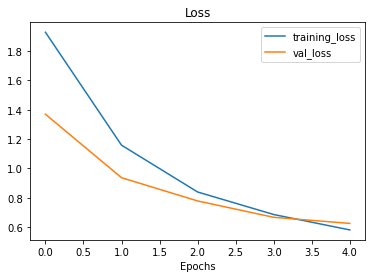

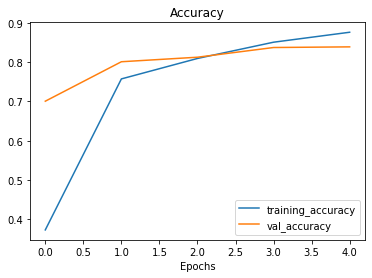

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model


The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.


Shape after base_model: (None, 7, 7, 1280) input shape

After GlobalAveragePooling2D(): (None, 1280) 

Globalaveragepooling2D changes the above dimension to 2D and this becomes the input layer for the next layer

In [ ]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
#Understanding for GlobalAveragePooling2D() 
input_shape = (1, 4, 4, 3)  

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n") # middle dimension (4,4) are removed and becomes a feature vector
# it condenses the tensors and stores the info in (1,3) and retaining the entire data. This is feature extraction 

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

#2D global average pooled random tensor:[[-0.09368646 -0.45840448 -0.2885598 ]] <-- these are feature vectors
# We then add our own classification layer(dense) on the above feature vector. So no of classes as inputs is = to same output shape

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


We can see the tf.keras.layers.GlobalAveragePooling2D() layer condensed the input tensor from shape (1, 4, 4, 3) to (1, 3). 

It did so by averaging the input_tensor across the middle two axes.


In [ ]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (`tf.keras.layers.Dense()`), it also condenses the information found by the base model into a lower dimension **feature vector**.

## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:
0. `model_0`: As baseline model

1. `model_1`: Use feature extraction transfer learning on 1% of the training data with data augmentation.

2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation.

3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.

4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetB0` model within the `tf.keras.applications` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2022-07-06 16:46:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   280MB/s    in 0.5s    

2022-07-06 16:46:47 (280 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

Alright, looks like we've only got seven images of each class, this should be a bit of a challenge for our model.


In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
len(train_data_1_percent), len(test_data)

(3, 79)

Data loaded. Time to augment it.

### Adding data augmentation right into the model

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model. Using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module and creating a dedicated data augmentation layer.

Adding a data augmentation layer to the model has the following benefits:

* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster) ie ImageDataGen does it on CPU while preprocesing does it on GPU

  * Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.

* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.


To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

The data augmentation transformations we're going to use are:
* [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip) - flips image on horizontal or vertical axis.

* [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomRotation) - randomly rotates image by a specified amount.

* [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomZoom) - randomly zooms into an image by specified amount.

* [RandomHeight](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomHeight) - randomly shifts image height by a specified amount.

* [RandomWidth](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomWidth) - randomly shifts image width by a specified amount.

* [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using the `tf.keras.applications` implementation of `EfficientNetB0`, it's not required.

There are more option but these will do for now.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"), # customers will take food images in straight line so we don't want vertical flip
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

Our data augmentation Sequential model is ready to go. 

But before we do that, let's test it out by passing random images through it

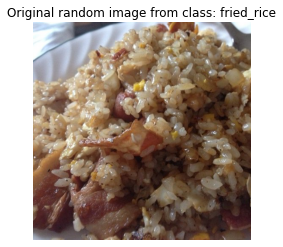

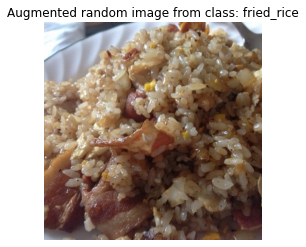

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os # for directories
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path

img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

Doing this will make our training dataset a little more varied. We can think of it as if we were taking a photo of food in real-life, not all of the images are going to be perfect, some of them are going to be orientated in strange ways. These are the kind of images we want our model to be able to handle.

Speaking of model, let's build one with the Functional API. We'll run through all of the same steps as before except for one difference, we'll add our data augmentation Sequential model as a layer immediately after the input layer.

###Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False) # whole model- inside the brackets

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # just a layer therefore x is outside

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")]) # dir_name,experiment_name

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220706-171500
Epoch 1/5
3/3 [==============================] - 9s 2s/step - loss: 2.4272 - accuracy: 0.1000 - val_loss: 2.1782 - val_accuracy: 0.2188
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.2095 - accuracy: 0.2143 - val_loss: 2.0647 - val_accuracy: 0.2977
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9863 - accuracy: 0.3857 - val_loss: 1.9619 - val_accuracy: 0.3832
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8250 - accuracy: 0.5000 - val_loss: 1.8820 - val_accuracy: 0.4128
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6546 - accuracy: 0.6143 - val_loss: 1.7987 - val_accuracy: 0.4589


In [ ]:
# Check out model summary
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

We've now got data augmentation built right into the our model. This means if we saved it and reloaded it somewhere else, the data augmentation layers would come with it.

The important thing to remember is data augmentation only runs during training. So if we were to evaluate or use our model for inference (predicting the class of an image) the data augmentation layers will be automatically turned off.

To see this in action, let's evaluate our model on the test data.


In [ ]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data) # full data and not 25% 
results_1_percent_data_aug

79/79 [==============================] - 6s 72ms/step - loss: 1.8056 - accuracy: 0.4556


[1.8055588006973267, 0.45559999346733093]

The results here may be slightly better/worse than the log outputs of our model during training because during training we only evaluate our model on 25% of the test data using the line validation_steps=int(0.25 * len(test_data)). Doing this speeds up our epochs but still gives us enough of an idea of how our model is going.

Let's stay consistent and check out our model's loss curves.


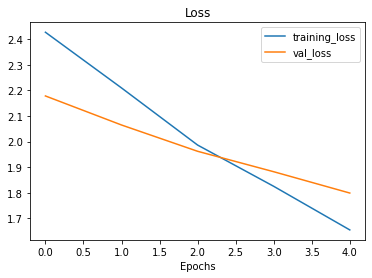

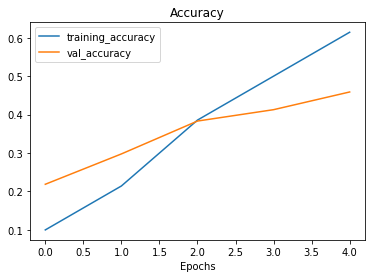

In [ ]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

It looks like the metrics on both datasets would improve if we kept training for more epochs. But we'll leave that for now. We'll jump to Model_2

###Model 2: Feature extraction transfer learning with 10% of data and data augmentation

Let's scale our 1% training data augmentation experiment up to 10% training data augmentation. 

We're going to run through the exact same steps as the previous model, the only difference being using 10% of the training data instead of 1%.


In [ ]:
# Get 10% of the data of the 10 classes 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

--2022-07-06 17:20:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.220.208, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.220.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   195MB/s    in 0.8s    

2022-07-06 17:20:55 (195 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
len(train_data_10_percent),len(test_data)

(24, 79)

We've got 10x more images to work with, 75 per class instead of 7 per class.

Let's build a model with data augmentation built in. We could reuse the data augmentation Sequential model we created before but we'll recreate it to practice.

In [ ]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model(aka backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # include_top is close to output layer
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_2.summary()# same as model_0 with data augmentation layer 

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint callback

Our model is compiled and ready to be fit

For this experiment we're going to introduce a new callback, the `ModelCheckpoint` callback.

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives us the ability to save our model, as a whole in the [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains. 


This is helpful if we think our model is going to be training for a long time and we want to make backups of it as it trains. It also means if we think our model could benefit from being trained for longer, we can reload it from a specific checkpoint and continue training from there.

For example, say we fit a feature extraction transfer learning model for 5 epochs and yweou check the training curves and see it was still improving and we want to see if fine-tuning for another 5 epochs could help, we can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.


But first, let's create a `ModelCheckpoint` callback. To do so, we have to specifcy a directory we'd like to save to.

Earlier we used callbacks [create_tensorboard_callback("dir_name", "experiment_name")] ie saving all the params as a whole

In [ ]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only- lot quicker
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

Difference between saving the entire model (SavedModel format) and saving the weights only is as follows:

The [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload our model exactly how it is elsewhere. 

However, if we do not want to share all of these details with others, we may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). 

Again, if disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

Time to fit the model.

Because we're going to be fine-tuning it later, we'll create a variable `initial_epochs` and set it to 5 to use later.

We'll also add in our `checkpoint_callback` in our list of `callbacks`.

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs, # we used len(train_data_10_percent)
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback]) # checkpoint_callback the additional parameter

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220706-173043
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0385 - accuracy: 0.3360
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 17s 471ms/step - loss: 2.0385 - accuracy: 0.3360 - val_loss: 1.5095 - val_accuracy: 0.6497
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3836 - accuracy: 0.6427
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 396ms/step - loss: 1.3836 - accuracy: 0.6427 - val_loss: 1.0628 - val_accuracy: 0.7664
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0954 - accuracy: 0.7053
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 548ms/step - loss: 1.0954 - accuracy: 0.7053 - val_loss: 0.8948 - val_accuracy: 0.7796
E

In [ ]:
model_0.evaluate(test_data)# check for model_2 below, model_0 is without data augmentation while model_2 is

79/79 [==============================] - 7s 72ms/step - loss: 0.6110 - accuracy: 0.8384


[0.6110387444496155, 0.8384000062942505]

Looks like our ModelCheckpoint callback worked and our model saved its weights every epoch without too much overhead (saving the whole model takes longer than just the weights).

Let's evaluate our model and check its loss curves.

In [ ]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 72ms/step - loss: 0.6955 - accuracy: 0.8160


[0.6955167651176453, 0.8159999847412109]

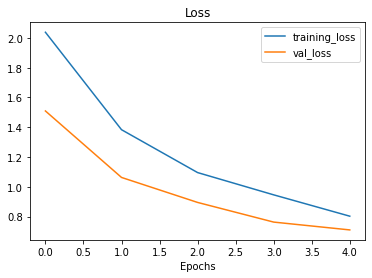

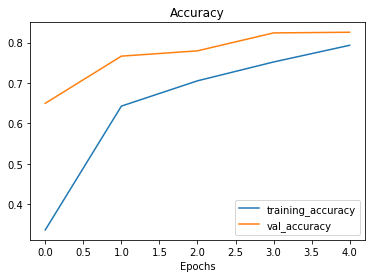

In [ ]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

Looking at these, our model's performance with 10% of the data and data augmentation isn't as good as the model with 10% of the data without data augmentation (see `model_0` results above), however the curves are trending in the right direction, meaning if we decided to train for longer, its metrics would likely improve.

Since we checkpointed our model's weights, we might as well see what it's like to load it back in. We'll be able to test if it saved correctly by evaluting it on the test data.

To load saved model weights we can use the the [`load_weights()`](https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_options) method, passing it the path where our saved weights are stored.

In [ ]:
# Load in saved model weights and evaluate model-- check if above values match with load_weights
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.6955 - accuracy: 0.8160


Now let's compare the results of our previously trained model and the loaded model. These results should very close if not exactly the same. The reason for minor differences comes down to the precision level of numbers calculated.

In [ ]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-5.96046448e-08  0.00000000e+00]


###Model 3: Fine-tuning an existing model on 10% of the data

High-level example of fine-tuning with EfficientNet model. 

Bottom layers (layers closer to the input data and important features are kept frozen) stay frozen where as top layers (layers closer to the output data ie secondary features are changed for better performance) are updated during training.

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (EfficientNetB0) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

Fine-tuning usually works best AFTER training a feature extraction model(train the weights in the output layer and then unfreeze some of the layers close to output) for a few epochs and with large amounts of data.


In [ ]:
model_2.layers

In [ ]:
#Check which layers are trainable
for layers in model_2.layers:
  print(layers.trainable) # our EfficientNetB0 is not yet trainable

True
True
False
True
True


In [ ]:
#Whic layers are there in the base model
for i, layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable) # around 236 layers are frozen

0 input_7 False
1 rescaling_6 False
2 normalization_6 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
model_2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

it looks like all of the layers in the efficientnetb0 layer are frozen. We can confirm this using the trainable_variables attribute.

In [ ]:
# How many layers are trainable in our base model?
print(len(model_2.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)
#This is the same as our base model.
print(len(base_model.trainable_variables))

0
0


In [ ]:
#We can even check layer by layer to see if the they're trainable.
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_7 False
1 rescaling_6 False
2 normalization_6 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

To begin fine-tuning, we'll unfreeze the entire base model by setting its trainable attribute to True. Then we'll refreeze every layer in the base model except for the last 10 by looping through them and setting their trainable attribute to False.

*** Finally, we'll recompile the model.***

In [ ]:
base_model.trainable = True # all the layers in  base model are trainable

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False # all the layers except the last 10 are now frozen

# Recompile the model (always recompile after any adjustments to a model) base_model is in model_2 so it understands while compiling
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              # lr is 10x lower than before so that unfrozen layers and update the weights during fine-tuning and also avoid over-fitting
              # we are updating already learned patterns/weights in the existing model, we don't want the weights to be updated too much, so we keep lr lower than usual to avoid overfitting
              #lr dictates how much the model should update its internal patterns/weights epochs to epochs/sample to sample
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Now let's check which layers of the pretrained model are trainable.

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_7 False
1 rescaling_6 False
2 normalization_6 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

All layers except for the last 10 are frozen and untrainable. This means only the last 10 layers of the base model along with the output layer will have their weights updated during training.

Every time we make a change to our models, we need to recompile them.

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (0.0001 instead of Adam's default of 0.001).

We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.

There's no set standard for setting the learning rate during fine-tuning, though reductions of 2.6x-10x+ seem to work well in practice.

How many trainable variables do we have now.



In [ ]:
print(len(model_2.trainable_variables))

12


It looks like our model has a total of 12 trainable variables, the last 10 layers of the base model and the weight and bias parameters of the Dense output layer.

Time to fine-tune!

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we can use the `initial_epoch` parameter of the [`fit()`](https://keras.rstudio.com/reference/fit.html) method. We'll pass it the last epoch of the previous model's training history (`history_10_percent_data_aug.epoch[-1]`).

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable base_model layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220706-180555
Epoch 5/10
24/24 [==============================] - 17s 433ms/step - loss: 0.7099 - accuracy: 0.7947 - val_loss: 0.5609 - val_accuracy: 0.8273
Epoch 6/10
24/24 [==============================] - 8s 309ms/step - loss: 0.5723 - accuracy: 0.8387 - val_loss: 0.5072 - val_accuracy: 0.8421
Epoch 7/10
24/24 [==============================] - 9s 380ms/step - loss: 0.5142 - accuracy: 0.8387 - val_loss: 0.5007 - val_accuracy: 0.8388
Epoch 8/10
24/24 [==============================] - 9s 356ms/step - loss: 0.4631 - accuracy: 0.8560 - val_loss: 0.4864 - val_accuracy: 0.8438
Epoch 9/10
24/24 [==============================] - 7s 278ms/step - loss: 0.4288 - accuracy: 0.8747 - val_loss: 0.4929 - val_accuracy: 0.8306
Epoch 10/10
24/24 [==============================] - 9s 353ms/step - loss: 0.3755 - accuracy: 0.8827 - val_loss: 0.5030 - val_accuracy: 0.8372


Fine-tuning is taking far longer per epoch than feature extraction (due to updating more weights throughout a network).


In [ ]:
# Evaluate the model on the test data(model_3 which is model_2 fine tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.4918 - accuracy: 0.8392


The results from evaluating the model might be slightly different to the outputs from training since during training we only evaluate on 25% of the test data.

We need a way to evaluate our model's performance before and after fine-tuning. We'll write a function to compare the before and after!


In [ ]:
#plot_loss_curve fn works great for models which have been only fit once but not for before and after fine tuning
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects. model_2 and model_3 ie before and after fine tuning
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.335999995470047, 0.6426666378974915, 0.7053333520889282, 0.7519999742507935, 0.7933333516120911, 0.7946666479110718, 0.8386666774749756, 0.8386666774749756, 0.8560000061988831, 0.874666690826416, 0.8826666474342346]


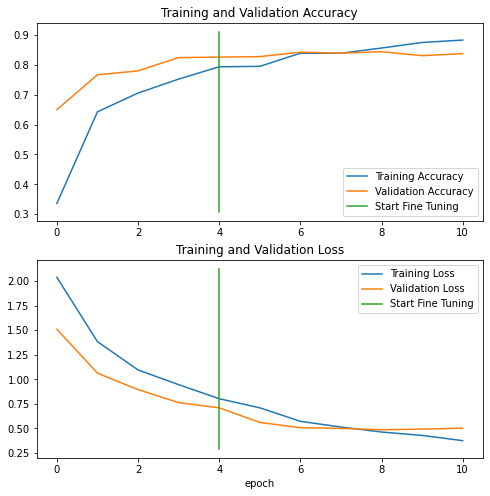

In [ ]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

It seems like the curves are heading in the right direction after fine-tuning.

###Model 4: Fine-tuning an existing model all of the data


In [ ]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2022-07-06 18:09:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   189MB/s    in 2.6s    

2022-07-06 18:09:12 (189 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


We've got 10x more images in of the training classes to work with.

The test dataset is the same we've been using for our previous experiments.

As it is now, our model_2 has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

To demonstrate this, we'll first evaluate the current model_2.


In [ ]:
# Evaluate model (this is the fine-tuned 10 percent on data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.4918 - accuracy: 0.8392


[0.49178817868232727, 0.8392000198364258]

In [ ]:
results_fine_tune_10_percent

[0.4917881488800049, 0.8392000198364258]

Now we'll revert the model back to the saved weights i.e to train a fine tune model_4, we need to revert model_2 back to its feature extraction weights. 

Loading model from earlier saved checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from. 

We want to load the model back to Start Fine Tuning Stage(above graph) as model_3 started from Start Fine Tuning Stage

In [ ]:
model_2.load_weights(checkpoint_path) # revert model back to saved weights

And the results should be the same as results_10_percent_data_aug.

In [ ]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data) # model_2 now reverted back to feature extraction level

79/79 [==============================] - 6s 72ms/step - loss: 0.6955 - accuracy: 0.8160


[0.6955170035362244, 0.8159999847412109]

In [ ]:
# Check to see if the above two results are the same (they should be)
results_10_percent_data_aug

[0.6955167651176453, 0.8159999847412109]

What we actually did in the above steps is as follows:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using `ModelCheckpoint`. (Model_2)

2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen. (Model_3)

3. Saved the results and training logs each time.

4. Reloaded the model from 1 to do the same steps as 2 but with all of the data.


Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [ ]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)
# though we reverted the weights, the base layer have unfrozen for bottom 10

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_7 False
1 rescaling_6 False
2 normalization_6 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

The last 10 layers are trainable (unfrozen).

We've got one more step to do before we can begin fine-tuning.

To Recompile them!

In [ ]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Time to fine-tune on all of the data!

In [ ]:
# Continue to train and fine-tune the model to our data. Because of fine tuning+ more data x10,epochs time increases
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220706-181822
Epoch 5/10
235/235 [==============================] - 60s 229ms/step - loss: 0.7256 - accuracy: 0.7623 - val_loss: 0.4044 - val_accuracy: 0.8717
Epoch 6/10
235/235 [==============================] - 48s 202ms/step - loss: 0.5904 - accuracy: 0.8088 - val_loss: 0.3952 - val_accuracy: 0.8783
Epoch 7/10
235/235 [==============================] - 45s 189ms/step - loss: 0.5326 - accuracy: 0.8276 - val_loss: 0.3682 - val_accuracy: 0.8964
Epoch 8/10
235/235 [==============================] - 42s 176ms/step - loss: 0.4926 - accuracy: 0.8393 - val_loss: 0.3728 - val_accuracy: 0.8947
Epoch 9/10
235/235 [==============================] - 39s 164ms/step - loss: 0.4501 - accuracy: 0.8549 - val_loss: 0.3415 - val_accuracy: 0.8997
Epoch 10/10
235/235 [==============================] - 37s 157ms/step - loss: 0.4255 - accuracy: 0.8628 - val_loss: 0.3475 - val_accuracy: 0.8865


Training took longer per epoch, but that makes sense because we're using 10x more training data than before.

Let's evaluate on all of the test data.

In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data) # model_4 actually
results_fine_tune_full_data

79/79 [==============================] - 6s 73ms/step - loss: 0.3176 - accuracy: 0.9008


[0.317632257938385, 0.9007999897003174]

It looks like fine-tuning with all of the data has given our model a boost, how do the training curves look?

5
11
[0.335999995470047, 0.6426666378974915, 0.7053333520889282, 0.7519999742507935, 0.7933333516120911, 0.7622666954994202, 0.8087999820709229, 0.8276000022888184, 0.8393333554267883, 0.8549333214759827, 0.8628000020980835]


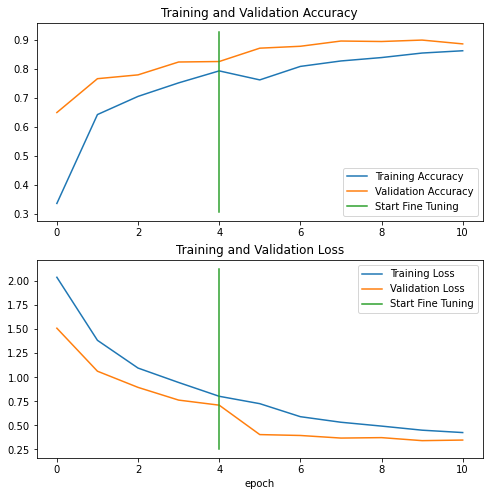

In [ ]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

Those graphs are looking great. And if we trained for longer, they might even keep improving.

## Viewing our experiment data on TensorBoard

Right now our experimental results are scattered all throughout our notebook. But thanks to the TensorBoard callback we made with our helper function `create_tensorflow_callback()`, we've been tracking our modelling experiments the whole time.

We upload them to TensorBoard.dev and check them out

We can do with the `tensorboard dev upload` command and passing it the directory where our experiments have been logged.


In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records # \ after transfer_learning is hint of new line

!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer learning experiments" \
--description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
--one_shot # exits the uploader when upload has finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main.py", line 46, in run_main
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 312, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 258, in _

Once we've uploaded the results to TensorBoard.dev we get a shareable link we can use to view and compare our experiments and share our results with others if needed.


In [ ]:
# View previous experiments
!tensorboard dev list


***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 312, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 258, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/program.py", line 276, in main
    return runner(self.flags) or 0
  File "/usr/local/lib/python3.7/dist-package

And if we want to remove a previous experiment (and delete it from public viewing) we can use the command:

tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID_TO_DELETE]


In [ ]:
# Remove previous experiments
# !tensorboard dev delete --experiment_id OUbW0O3pRqqQgAphVBxi8Q

# NoteBook 3 deals with 101 food image dataset with full data and will also complete the Trilogy of Food Vision 101 Project